In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from datetime import datetime
from pathlib import Path
import fsspec

A client asks you to develop a frost risk model for their strawberry farm in Plant City, Florida.  As a first step in that process, you would like to understand the occurrence of these events by month and some information about the atmospheric conditions that generate frost in the location based on climatological records.  You remember that your ATMS 523 professor back in graduate school taught you some tricks that might be able to help. Using the code provided from Module 3, load in the GHCN-D daily temperature records from Plant City (Station USC00087205).

(1) Strawberries are planted around October 1 and ready for harvest by the end of January. What is the mean risk of frost and freeze, defined as the mean number of days per month over the period 1991-2020 that the temperature has been observed to be less than or equal to 32 and 28 degrees Fahrenheit, respectively, that might damage the plants for each month during the October - January period? (25 points)

In [2]:
# Load in the appropriate txt files
S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}

colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()

inventory = pd.read_csv(
    S3_INVENTORY_TXT, sep=r'\s+', names=['ID','LAT','LON','ELEMENT','FIRSTYEAR','LASTYEAR'],
    dtype={'ID':str,'ELEMENT':str,'FIRSTYEAR':int,'LASTYEAR':int}, engine='python', storage_options=STOR
)

stations.head(), inventory.head()

(            ID  LATITUDE  LONGITUDE  ELEVATION STATE                   NAME  \
 0  ACW00011604   17.1167   -61.7833       10.1        ST JOHNS COOLIDGE FLD   
 1  ACW00011647   17.1333   -61.7833       19.2                     ST JOHNS   
 2  AE000041196   25.3330    55.5170       34.0          SHARJAH INTER. AIRP   
 3  AEM00041194   25.2550    55.3640       10.4                   DUBAI INTL   
 4  AEM00041217   24.4330    54.6510       26.8               ABU DHABI INTL   
 
   GSN_FLAG HCN_CRN_FLAG WMO_ID  
 0      NaN          NaN    NaN  
 1      NaN          NaN    NaN  
 2      GSN          NaN  41196  
 3      NaN          NaN  41194  
 4      NaN          NaN  41217  ,
             ID      LAT      LON ELEMENT  FIRSTYEAR  LASTYEAR
 0  ACW00011604  17.1167 -61.7833    TMAX       1949      1949
 1  ACW00011604  17.1167 -61.7833    TMIN       1949      1949
 2  ACW00011604  17.1167 -61.7833    PRCP       1949      1949
 3  ACW00011604  17.1167 -61.7833    SNOW       1949      194

In [3]:
# Identify stations in Indiana that have at least 30 years of data
coverage = (inventory.groupby('ID', as_index=False)
                    .agg(first=('FIRSTYEAR','min'), last=('LASTYEAR','max'))
                    .assign(years=lambda d: d['last'] - d['first'] + 1))

ind = (stations.loc[stations['STATE']=='FL', ['ID','NAME','STATE','LATITUDE','LONGITUDE','ELEVATION']]
              .merge(coverage, on='ID', how='inner'))
ind30 = ind[ind['years']>=30].copy()
ind30.sort_values(['years','ID'], ascending=[False, True]).head(12)

,ID,NAME,STATE,LATITUDE,LONGITUDE,ELEVATION,first,last,years
1826,USC00080478,BARTOW 1SE,FL,27.8864,-81.8325,34.1,1892,2025,134
1891,USC00082229,DELAND 1 SSE,FL,29.0097,-81.2986,7.6,1892,2025,134
1903,USC00082944,FERNANDINA BEACH,FL,30.6669,-81.4525,14.9,1892,2025,134
1958,USC00084731,LAKE CITY 2 E,FL,30.1853,-82.5942,59.4,1892,2025,134
2021,USC00086414,OCALA,FL,29.1639,-82.0778,22.9,1892,2025,134
2060,USC00087205,PLANT CITY,FL,28.0208,-82.1392,33.2,1892,2025,134
2116,USC00088824,TARPON SPGS SEWAGE PLT,FL,28.1522,-82.7539,1.8,1892,2025,134
2179,USW00012835,FT MYERS PAGE FLD AP,FL,26.5850,-81.8614,4.0,1892,2025,134
2184,USW00012841,ORLANDO EXECUTIVE AP,FL,28.5467,-81.3356,31.7,1892,2025,134
1822,USC00080369,AVON PARK 2 W,FL,27.5947,-81.5267,46.9,1892,2022,131


In [4]:
# Take the file for the Plant City station
PLc = 's3://noaa-ghcn-pds/csv/by_station/USC00087205.csv'

In [9]:
# Write and call a function that returns the mean number of days per month over the 1991-2020 period that has temperatures
# reaching frost and freeze temperatures of 32 and 28 Fahrenheit, respectively. Do this for the strawberry growing season of October 1 - January 31
# Use TMIN to determine this

def load_station_daily(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options=STOR, dtype={'ID': str, 'ELEMENT': str}, parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index=['ID', 'DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index())
    if 'TMIN' in wide:
        wide['TMIN'] = (wide['TMIN'] / 10.0) * 9/5 + 32
    wide = wide[(wide['DATE'].dt.year >= 1991) & (wide['DATE'].dt.year <= 2020)]
    wide['month'] = wide['DATE'].dt.month
    wide = wide[wide['month'].isin([10, 11, 12, 1])]
    wide['frost_day']  = wide['TMIN'] <= 32
    wide['freeze_day'] = wide['TMIN'] <= 28
    monthly_counts = (
        wide.groupby([wide['DATE'].dt.year, 'month'])
        .agg(frost_days=('frost_day', 'sum'), freeze_days=('freeze_day', 'sum')).reset_index().rename(columns={'DATE': 'year'}))
    
    climatology = (
        monthly_counts.groupby('month').agg(mean_frost_days=('frost_days', 'mean'), mean_freeze_days=('freeze_days', 'mean')).reset_index())

    return climatology

frames = []
w = load_station_daily(PLc)
frames.append(w)
print(w)


/tmp/ipykernel_254832/750069767.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options=STOR, dtype={'ID': str, 'ELEMENT': str}, parse_dates=['DATE'])


   month  mean_frost_days  mean_freeze_days
0      1         1.866667          0.500000
1     10         0.000000          0.000000
2     11         0.033333          0.000000
3     12         0.600000          0.166667


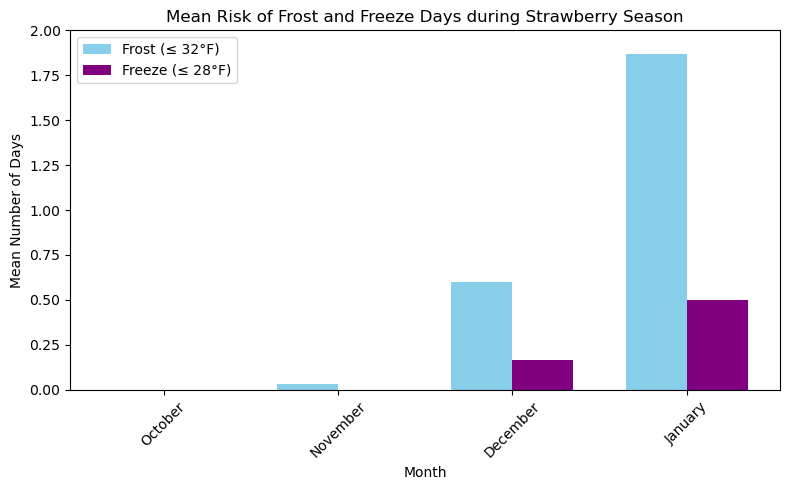

In [21]:
# Plot the results 

months_labels = ['October', 'November', 'December', 'January']
x = np.arange(len(months_labels))
frost = np.array([0, 0.03, 0.6, 1.866667])
freeze = np.array([0, 0, 0.166667, 0.5])

# Bar width
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, frost, width, label='Frost (≤ 32°F)', color='skyblue')
ax.bar(x + width/2, freeze, width, label='Freeze (≤ 28°F)', color='purple')

# Labels and title
ax.set_xticks(x)
ax.set_xticklabels(months_labels, rotation=45)
ax.set_ylabel('Mean Number of Days')
ax.set_xlabel('Month')
ax.set_title('Mean Risk of Frost and Freeze Days during Strawberry Season')
ax.set_ylim(0,2)
ax.legend()

plt.tight_layout()
plt.show()

# Descriptive Answer to question 1: In general, the risk of damage to the strawberries increases as the season goes on. There is no risk in October and little if any risk in November. Risk increases substantially in December and particularly January during the peak of Northern Hemisphere winter. Even so, from 1991-2020, an average of less than 2 days in January sees a frost and on average less than 1 day sees a freeze, so these events are not very common in Plant City, Florida. There will be several seasons where a frost or freeze is never seen during the growing season. If the client wishes, they can have precautions in place in case of a frost or freeze in the late growing season, but the risk remains relatively low. 

(2) To begin to explore the seasonal to sub-seasonal prediction of freeze events at this site, using code you adapt from Module 4, we're going to try to relate these cold events to the El Nino Southern Oscillation (ENSO).  You have a hypothesis that ENSO is related to seasonal prediction of freeze events, but you don't know which region to choose for calculating your anomalies.  The problem is that there are many ENSO indicies that represent forcing across the eastern and central Pacific: which SST forcing region is most related to cold conditions in central Florida?

(2 continued) NOAA CPC has calculated mean SSTs and anomalies in each of these 4 regions (cpc.ncep.noaa.gov/data/indices/sstoi.indicesLinks to an external site.). Using the temperature anomalies computed in the file, determine which ENSO index (NINO1+2, NINO3, NINO4, and NINO3.4) is best correlated (i.e., has the highest absolute value of Pearson's correlation coefficient) with the number of days per month < 28 degrees F.  (25 points)

In [23]:
# Load the climate indices csv file
ENSO = pd.read_csv('/data/keeling/a/mgraber2/Course scripts/ATMS523/Final/ATMS523_climateindices.csv')

In [26]:
# Use the anomalies only and only use October, November, December, and January
# Anom = NINO1+2, Anom.1 = NINO3, ANOM.2 = NINO4, ANOM.3 = NINO3.4
ENSO = ENSO[['YR', 'MON', 'ANOM', 'ANOM.1', 'ANOM.2', 'ANOM.3']]
ENSO = ENSO[ENSO['MON'].isin([1, 10, 11, 12])]

In [29]:
# Define a function similar to the previous one that counts up the number of days per month in 1991-2020 where the temperature
# is below 28 degrees
def count_freeze_days(url: str) -> pd.DataFrame:
    df = pd.read_csv(url,storage_options=STOR,dtype={'ID': str, 'ELEMENT': str},parse_dates=['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = df.pivot_table(index=['ID', 'DATE'], columns='ELEMENT', values='DATA_VALUE', aggfunc='first').reset_index()
    if 'TMIN' in wide:
        wide['TMIN'] = (wide['TMIN'] / 10.0) * 9/5 + 32
    wide = wide[(wide['DATE'].dt.year >= 1991) & (wide['DATE'].dt.year <= 2020)]
    wide['month'] = wide['DATE'].dt.month
    wide = wide[wide['month'].isin([10, 11, 12, 1])]
    wide['freeze_day'] = wide['TMIN'] < 28
    monthly_counts = (wide.groupby([wide['DATE'].dt.year, 'month']).agg(freeze_days=('freeze_day', 'sum')).reset_index()
                      .rename(columns={'DATE': 'year', 'DATE': 'year'}))
    monthly_counts = monthly_counts.rename(columns={'DATE': 'year', 'DATE': 'year'})
    return monthly_counts
frames = []
w = count_freeze_days(PLc)
frames.append(w)
monthly_freeze_days = pd.concat(frames, ignore_index=True)
print(monthly_freeze_days)

/tmp/ipykernel_254832/350324761.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url,storage_options=STOR,dtype={'ID': str, 'ELEMENT': str},parse_dates=['DATE'])


     year  month  freeze_days
0    1991      1            0
1    1991     10            0
2    1991     11            0
3    1991     12            0
4    1992      1            0
..    ...    ...          ...
115  2019     12            0
116  2020      1            0
117  2020     10            0
118  2020     11            0
119  2020     12            0

[120 rows x 3 columns]


In [39]:
# Define the variables that will be used for plotting
freeze_days = monthly_freeze_days['freeze_days'].values
NINO12 = ENSO['ANOM'].values
NINO3 = ENSO['ANOM.1'].values
NINO4 = ENSO['ANOM.2'].values
NINO34 = ENSO['ANOM.3'].values

In [40]:
from scipy import stats
# Compute the pearson correlation between the number of freeze days and each ENSO indice
NINO12_cc, NINO12_p = stats.pearsonr(freeze_days, NINO12)
NINO3_cc, NINO3_p = stats.pearsonr(freeze_days, NINO3)
NINO4_cc, NINO4_p = stats.pearsonr(freeze_days, NINO4)
NINO34_cc, NINO34_p = stats.pearsonr(freeze_days, NINO34)

print(f"The Pearson correlation between the NINO1+2 Index and freeze days is {NINO12_cc}")
print(f"The Pearson correlation between the NINO3 Index and freeze days is {NINO3_cc}")
print(f"The Pearson correlation between the NINO4 Index and freeze days is {NINO4_cc}")
print(f"The Pearson correlation between the NINO3.4 Index and freeze days is {NINO34_cc}")

The Pearson correlation between the NINO1+2 Index and freeze days is -0.13562908779006885
The Pearson correlation between the NINO3 Index and freeze days is -0.12246262813166826
The Pearson correlation between the NINO4 Index and freeze days is -0.13514838469133997
The Pearson correlation between the NINO3.4 Index and freeze days is -0.11203860185234232


# The ENSO1+2 index has the highest correlation with the NINO4 index coming in at a close 2nd. Physically this makes sense since Florida is the closest to these two locations so the teleconnections should be strongest between these two. The correlation is not terribly high and this makes sense since the sample size for the number of freeze days is relatively small. In Plant City, Florida it very rarely gets below 28 degrees so since the sample is small, the overall correlation is going to be a little bit weaker. In general, the strawberry farmer should not have to worry too much about seeing many days where it gets below 28 degrees, but the most reliable ENSO index to use for a model is the NINO1+2 index. 

Text(0, 0.5, 'Number of freeze days per month')

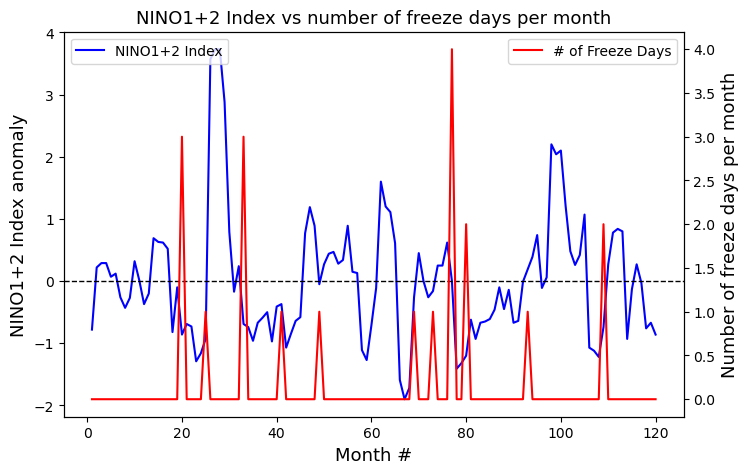

In [53]:
# Plot the number of freeze days per month with the ENSO1+2 index for visualization purposes
fig, ax1 = plt.subplots(figsize=(8,5))
months = np.arange(1,121,1)
ax2 = ax1.twinx()
ax1.plot(months, NINO12, color='blue', label='NINO1+2 Index')
ax2.plot(months, freeze_days, color='red', label='# of Freeze Days')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('NINO1+2 Index vs number of freeze days per month', fontsize=13)
ax1.set_xlabel('Month #', fontsize=13)
ax1.set_ylabel('NINO1+2 Index anomaly', fontsize=13)
ax2.set_ylabel('Number of freeze days per month', fontsize=13)

# In general, many of the months where the NINO index is less than 0, it is more likely that there will be freeze days in those months, which is what causes the weak negative correlation. While not enough to definitively say that it is more likely there will be freeze days when the NINO1+2 index is less than 0, it is the conclusion that can be made based on the available data. 